# Physics-Informed Machine Learning
Timon Palm

## 1D Linear Pertubated Wave Equation

$$ \frac{\partial^2{u}}{\partial{t^2}} = \frac{\partial^2{u}}{\partial{x^2}} -3u, \quad x \in [0, \pi], \quad t \in [0,1]$$

with inital and boundary conditions:

$$u(x,0) = 0, \quad \frac{\partial{u}}{\partial{t}}\biggr|_{t=0} = 2 \cos(x), \quad u(0,t) = \sin(2t), \quad u(\pi, t) = -\sin(2t)$$

and exact solution:

$$u_{exact}(x,t) = \cos(x)\sin(2t)$$

In [73]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import torch

In [74]:
def exact_solution(x, t):
    return np.cos(x) * np.sin(2 * t)

In [75]:
def plot_function(U, X, T, title: str, sample_points: np.array=None):
    fig = plt.figure(figsize=(12, 6))
    plt.title(title)
    ax = fig.add_subplot(121)
    plt.xlabel("x")
    plt.ylabel("t")
    c = ax.pcolormesh(X, T, U, cmap="coolwarm")
    fig.colorbar(c, ax=ax)

    if sample_points is not None:
        ax.scatter(sample_points[:, 0], sample_points[:, 1], color="black", alpha=0.5, s=2)

    ax = fig.add_subplot(122, projection="3d")
    ax.plot_surface(X, T, U, cmap="coolwarm")
    ax.view_init(30, 30)

    plt.xlabel("x")
    plt.ylabel("t")

    plt.show()

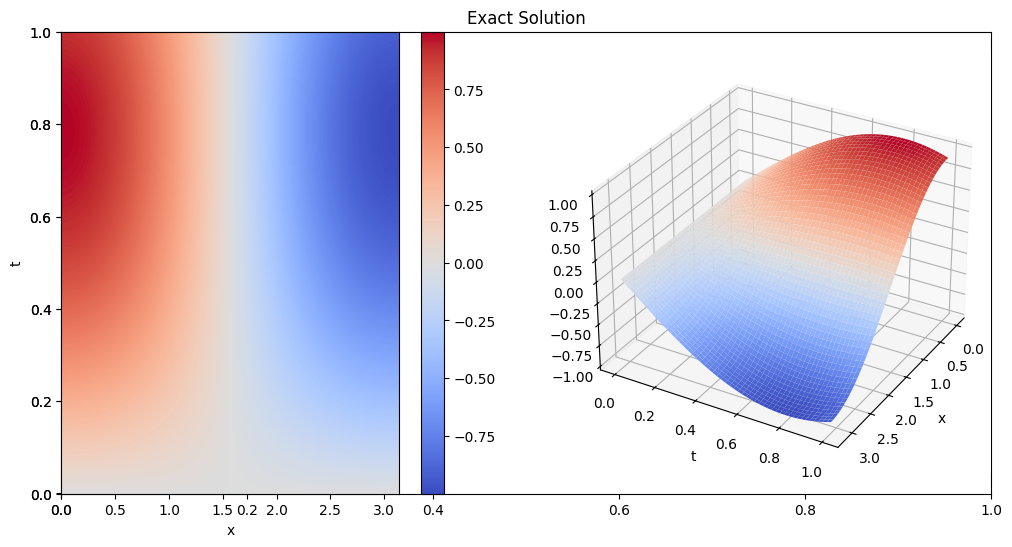

In [76]:
x = np.linspace(0, np.pi, 1000)
t = np.linspace(0, 1, 1000)

X, T = np.meshgrid(x, t)

U = exact_solution(X, T)

plot_function(U, X, T, "Exact Solution")

## Part A: Theory

### Explain how physics-informed neural networks (PINNs) can be used to solve the above PDE.

**What is the role of the neural network in this approach?**

We have the unknown solution $u(x,t)$, which is potentially a very complex function. In PINN, we utilize the efficacy of neural networks to approximate functions and use neural networks  as a surrogate for the unknown function $u(x,t) \approx NN(x,t;\Theta)$. Thus, the neural network is a function of $u$, $t$ and its adjustible weights $\Theta$. PDEs can involve partial derivatives or in this case second partial derivatives $\frac{\partial^2{u}}{\partial{t^2}}$ and $\frac{\partial^2{u}}{\partial{x^2}}$, which can be easily obtained by exploiding auto-differentiation as $u$ is the neural network.

**How are the PDE, inital conditions and boundary conditions incorporated into the loss functions?**

Typically, the loss of a PINN $u(x,t) \approx NN(x,t,\Theta)$ consists of initial, boundary and residual term. 

$$\mathcal{L} = \mathcal{L}_i + \mathcal{L}_b + \mathcal{L}_r$$

**Initial**: The inital term in the loss constraints the model to obey to the initial conditions. In this case, we have two initial conditions $u(x,0) = 0, \quad \frac{\partial{u}}{\partial{t}}\biggr|_{t=0} = 2 \cos(x)$, which both get regularized by the Mean Squared Error over a set of $I$ initial states $(x_j,0) \forall j \in [1,\dots,I]$:

$$\mathcal{L}_i = \sum_{j=1}^I \|NN(x_j,0;\Theta)\|^2 + \|\frac{\partial{NN(x_j,t_j;\Theta)}}{\partial{t_j}}\biggr|_{t_j=0} - 2 \cos(x_j)\|^2$$

**Boundary**: The boundary term of the PINN-loss ensures that the all boundary conditions are satisfied. In this case, there are two boundary conditions $u(0,t) = \sin(2t)$ and $u(\pi, t) = -\sin(2t)$. The model should output these values for $x=0$ and $x=\pi$, respectively. Similar to the initial term, we use the Mean Squared Error to keep the output $NN(x,t;\Theta)$ for $x=0$ and $x=\pi$ close to the desired values. This results in the loss function:

$$\mathcal{L}_b = \sum_{j=1}^{B}\|NN(0,t_j;\Theta) - \sin(2t_j)\|^2 + \|NN(\pi,t_j;\Theta) + \sin(2t_j)\|^2$$

for $(x_j,0) \forall j \in [1,\dots,B]$ boundary points.

**Residual**: In the residual, the actual PDE or ODE is incorporated into the neural network to impose the model to adhere to the differential equation. For that, the PDE is formulated as:

$$0 = \frac{\partial^2{NN(uxt;\Theta)}}{\partial{x^2}} -3{NN(x,t;\theta)} -\frac{\partial^2{NN(x,t;\Theta)}}{\partial{t^2}}, \quad x \in [0, \pi], \quad t \in [0,1]$$

Similar to the other terms, we peanalize it by the Mean Squared Error. This leads to the residual term:

$$\mathcal{L}_r = \sum_{j=1}^{R} \| \frac{\partial^2{NN(x_j,t_j;\theta)}}{\partial{x_j^2}} -3NN(x_j,t_j;\Theta) -\frac{\partial^2{NN(x_j,t_j;\Theta)}}{\partial{t_j^2}} \|^2$$

for $(x_j,0) \forall j \in [1,\dots,R]$ residual points.

**Why are collocation points important in PINNs?**

PINNs learn in an unsupervised fashion - there is no groundtruth. It is purely guided by the loss function. In PINNs, we try to model a continous PDE. Collocation points discretize this function in order to be evaluated. The model will try to fit those collocation points with a function and we can only "guide" the neural network at those specific points. Imagining that we only use collocation points of a subspace of the models domain, it will perform well at these collocation points but outside this region, the model can take any value.

So ideally, the collocation points are chosen, such that they cover the entire function space well. That can be uniform or random.

Furthermore, if it is known that the function exhibits rapid changes in some areas it might be benificial to take more points from there.

### Discuss the advantages of using PINNs over traditional numerical methods (e.g. finite difference or finite element methods) and pure data-driven approaches (e.g., standard neural networks) for solving PDEs. Also, mention potential challenges of using PINNs.


**Advantages of PINNs**
1. **Mesh-Free Computation**
Unlike finite difference (FDM) or finite element methods (FEM), which require structured grids or meshes, PINNs operate in a mesh-free manner. This is particularly useful for solving PDEs in complex geometries or higher dimensions where meshing becomes expensive and challenging.

1. **Smooth and Continuous Solutions**
Traditional numerical methods often introduce discretization errors and may require interpolation for obtaining values between grid points. PINNs, on the other hand, provide continuous and differentiable solutions across the entire domain due to their neural network-based representation.

2. **Integration of Data and Physics**
* PINNs can incorporate both governing PDEs and observational data, making them more robust in scenarios where data is sparse or noisy.
* Purely data-driven methods (e.g., standard neural networks) require large amounts of labeled data, whereas PINNs leverage the underlying physics to reduce dependency on extensive datasets.

3. **High-Dimensional PDEs**
Traditional numerical methods struggle with the "curse of dimensionality," as computational cost increases exponentially with the number of dimensions. PINNs can handle high-dimensional PDEs more effectively by using deep learning techniques.

4. **Generalization to Different PDE Forms**
Once trained, PINNs can generalize to different boundary conditions, parameterized PDEs, and even inverse problems (e.g., discovering unknown coefficients in a PDE), unlike numerical methods that need to be reformulated for each new case.

5. **Efficient Handling of Inverse Problems**
PINNs can naturally solve inverse problems (e.g., parameter estimation, missing boundary conditions, or discovering unknown governing laws) without requiring iterative solvers, which are typically needed in traditional methods.

**Challenges and Limitations of PINNs**
1. **Training Complexity and Computational Cost**
Training PINNs requires solving an optimization problem, which can be computationally expensive and time-consuming, especially for complex PDEs.
Unlike traditional solvers with deterministic convergence, PINN training relies on gradient-based optimization, which may suffer from slow convergence or local minima.

2. **Hyperparameter Sensitivity**
The choice of neural network architecture (e.g., depth, width, activation functions) and hyperparameters (e.g., learning rate, weight coefficients for loss terms) significantly impacts the performance of PINNs. Poor choices can lead to suboptimal solutions or slow training.

3. **Balancing Loss Terms**
PINNs typically use a loss function that combines multiple terms (e.g., governing equations, initial/boundary conditions, and data). Properly weighting these terms is nontrivial and crucial for stable training. Imbalanced losses can lead to poor enforcement of PDE constraints or inadequate fitting to boundary conditions.

4. **Scalability to Complex Problems**
While PINNs work well for many PDEs, they may struggle with highly nonlinear or stiff equations where traditional numerical methods (e.g., implicit schemes) are well-suited. Training deep networks for large-scale problems requires significant computational resources (e.g., GPUs or TPUs).

5. **Generalization Issues**
PINNs may not always generalize well to regions of the domain with sparse training points, requiring adaptive sampling techniques or domain decomposition methods.
Unlike numerical solvers that guarantee accuracy through grid refinement, PINN accuracy depends on the quality of training data and optimization.

## Part B: Implementation

1. **Design a neural network architecture suitable for solving this problem. Justify your choices (e.g. number of layers, input layer, output layer, number of neurons per layer, activation functions).**

In [77]:
from dataclasses import dataclass


@dataclass
class Data:
    x_initial: torch.Tensor
    t_initial: torch.Tensor

    x_residual: torch.Tensor
    t_residual: torch.Tensor

    x_boundary_1: torch.Tensor
    t_boundary_1: torch.Tensor

    x_boundary_2: torch.Tensor
    t_boundary_2: torch.Tensor


@dataclass
class Solution:
    initial: torch.Tensor
    residual: torch.Tensor
    boundary_1: torch.Tensor
    boundary_2: torch.Tensor

In [78]:
class PINN_model(torch.nn.Module):
    def __init__(self, n_layers, hidden_size):
        super(PINN_model, self).__init__()
        self.hidden_size = hidden_size

        self.in_layer = torch.nn.Linear(2, hidden_size) # input layer x,t -> hidden_size
        self.hidden_layers = [
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.Tanh(),
        ] * n_layers # hidden layers
        self.out_layer = torch.nn.Linear(hidden_size, 1) # output layer hidden_size -> 1

        self.layers = torch.nn.Sequential(
            self.in_layer, torch.nn.Tanh(), *self.hidden_layers, self.out_layer
        )

    def forward(self, data: Data) -> Solution:

        len_initial = len(data.x_initial)
        len_residual = len(data.x_residual)
        len_boundary_1 = len(data.x_boundary_1)

        # concat initial, residual, boundary 1 and boundary 2 points
        x = torch.cat(
            [data.x_initial, data.x_residual, data.x_boundary_1, data.x_boundary_2]
        ).unsqueeze(1)
        t = torch.cat(
            [data.t_initial, data.t_residual, data.t_boundary_1, data.t_boundary_2]
        ).unsqueeze(1)
        xt = torch.cat([x, t], dim=1)

        # pass through the network
        out = self.layers(xt).squeeze()

        # create Solution class with the predicted values
        res = Solution(
            initial=out[:len_initial],
            residual=out[len_initial : len_initial + len_residual],
            boundary_1=out[
                len_initial + len_residual : len_initial + len_residual + len_boundary_1
            ],
            boundary_2=out[len_initial + len_residual + len_boundary_1 :],
        )

        return res
    
    # for simpler prediction without the data class
    def predict(self, X, T):
        x = torch.tensor(X).float().unsqueeze(1)
        t = torch.tensor(T).float().unsqueeze(1)

        xt = torch.cat([x, t], dim=1)

        return self.layers(xt).squeeze().detach().numpy()

The above 1D PDE is a relatively simple and small problem, which does not require an intricate model architecture. I opt for a simple Multi-Layer Perceptron with a two dimensional input $[x,t]$ and a one dimensional output $u(x,t)$. The number of layers and their hidden dimension can be varied, I went for 5 layers and a hidden dimension of 50, though. I chose the $tanh$-nonlinearity, because the output $u(x,t)$ will also be in the range of $[-1,1]$, which further restricts the model.

2. **Write the total loss function for this problem.**

In [79]:
def nn_loss(u: Solution, data: Data, ddx, ddt, dt):
    residual = torch.mean((ddx - 3 * u.residual - ddt) ** 2) # residual loss

    # boundary loss for the two boundary conditions
    boundary = torch.mean((u.boundary_1 - torch.sin(2 * data.t_boundary_1)) ** 2) + torch.mean(
        (u.boundary_2 + torch.sin(2 * data.t_boundary_2)) ** 2
    )

    # initial condition loss
    initial = torch.mean(u.initial ** 2) + torch.mean((dt - 2 * torch.cos(data.x_initial))**2)

    return residual + boundary + initial, residual, boundary, initial

3. **Outline the training loop for the PINN.**

In [80]:
def train(model: PINN_model, data: Data, epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    losses = {
        "loss": [],
        "residual": [],
        "boundary": [],
        "initial": [],
    }
    for epoch in range(epochs):
        optimizer.zero_grad()

        u = model(data)

        sol = u.residual
        x = data.x_residual
        t = data.t_residual

        # calculate second derivative w.r.t. x
        dx = torch.autograd.grad(
            sol, x, grad_outputs=torch.ones_like(sol), create_graph=True
        )[0]
        ddx = torch.autograd.grad(
            dx, x, grad_outputs=torch.ones_like(sol), create_graph=True
        )[0]

        # calculate second derivative w.r.t. t
        dt = torch.autograd.grad(
            sol, t, grad_outputs=torch.ones_like(t), create_graph=True
        )[0]
        ddt = torch.autograd.grad(
            dt, t, grad_outputs=torch.ones_like(t), create_graph=True
        )[0]

        # calculate derivative w.r.t. t at t=0
        dt_initial = torch.autograd.grad(
            u.initial, data.t_initial, grad_outputs=torch.ones_like(data.t_initial), create_graph=True
        )[0]

        # calculate loss
        loss, loss_r, loss_b, loss_i = nn_loss(u, data, ddx, ddt, dt_initial)

        loss.backward()

        optimizer.step()
        
        losses["loss"].append(loss.item())
        losses["residual"].append(loss_r.item())
        losses["boundary"].append(loss_b.item())
        losses["initial"].append(loss_i.item())

        print(f"Epoch {epoch}, Loss: {loss.item()}, Residual: {loss_r.item()}, Boundary: {loss_b.item()}")

    return losses

4. **Train**

In [81]:
# helper function to generate n random initial points, n random residual points and n random boundary points
def generate_data(n):
    data = Data(
        x_initial=torch.rand(n) * torch.pi,
        t_initial=torch.zeros(n, requires_grad=True),
        x_residual=(torch.rand(n) * torch.pi).requires_grad_(),
        t_residual=torch.rand(n, requires_grad=True),
        x_boundary_1=torch.zeros(n),
        t_boundary_1=torch.rand(n),
        x_boundary_2=torch.ones(n) * torch.pi,
        t_boundary_2=torch.rand(n),
    )
    return data

Epoch 0, Loss: 3.4258084297180176, Residual: 0.21289749443531036, Boundary: 1.1814771890640259
Epoch 1, Loss: 3.29028582572937, Residual: 0.1364808976650238, Boundary: 1.1319607496261597
Epoch 2, Loss: 3.176568031311035, Residual: 0.07947945594787598, Boundary: 1.0828160047531128
Epoch 3, Loss: 3.084427833557129, Residual: 0.04203169420361519, Boundary: 1.0337367057800293
Epoch 4, Loss: 3.014415740966797, Residual: 0.025075756013393402, Boundary: 0.9843722581863403
Epoch 5, Loss: 2.967085838317871, Residual: 0.029329799115657806, Boundary: 0.9347177147865295
Epoch 6, Loss: 2.941694498062134, Residual: 0.05391623079776764, Boundary: 0.8853247761726379
Epoch 7, Loss: 2.934115409851074, Residual: 0.09422750025987625, Boundary: 0.8375178575515747
Epoch 8, Loss: 2.9357008934020996, Residual: 0.14075936377048492, Boundary: 0.7933598756790161
Epoch 9, Loss: 2.9357192516326904, Residual: 0.18177799880504608, Boundary: 0.7549583911895752
Epoch 10, Loss: 2.9264097213745117, Residual: 0.208751201

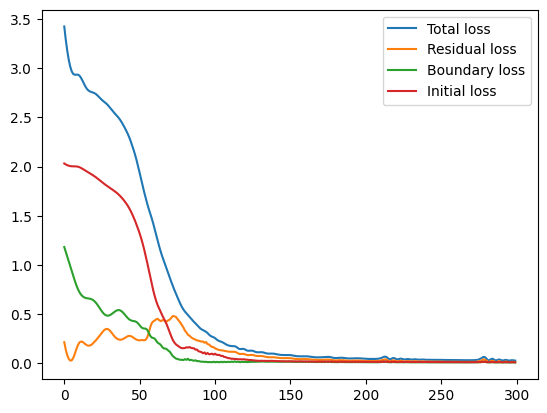

In [82]:
data = generate_data(1000)

model = PINN_model(n_layers=5, hidden_size=50)
losses = train(model, data, epochs=300)

# plot the loss
plt.plot(losses["loss"], label="Total loss")
plt.plot(losses["residual"], label="Residual loss")
plt.plot(losses["boundary"], label="Boundary loss")
plt.plot(losses["initial"], label="Initial loss")
plt.legend()
plt.show()

# Part C: Validation and Error Analysis

1. **Suppose you have trained the PINN and obtain a solution $u_{PINN}(x,t)$. Validate the solution by comparing it with the exact solution $u_{exact}(x,t)$.**

I would assess the quality of the model by the Mean Absolute Error over an equally spaced grid $(x_i, t_i)$ of $n$ points in the function's domain:

$$e_{mean} = \sum_{i=1}^{n} |u_{PINN}(x_i,t_i) - u_{exact}(x_i,t_i)|$$

It will give a measurement on how well the neural network can model the functions domain by average.

Additionally, the Maximum Absolute Error over the functions domain can assess if individual errors are bounded.

$$e_{max} = max(|u_{PINN}(x_i,t_i) - u_{exact}(x_i,t_i)|)$$

In [86]:
def mean_abs_error(pred, true):
    return np.mean(np.abs(pred - true))

def max_abs_error(pred, true):
    return np.max(np.abs(pred - true))

In [89]:
def plot_comparison():
    x = np.linspace(0, np.pi, 1000)
    t = np.linspace(0, 1, 1000)

    X, T = np.meshgrid(x, t)

    U = exact_solution(X, T)
    U_pred = model.predict(X.flatten(), T.flatten()).reshape(X.shape)

    plot_function(U, X, T, "Exact Solution")
    plot_function(U_pred, X, T, "Predicted Solution")

    diff = np.abs(U - U_pred)

    x = torch.cat(
        [data.x_initial, data.x_residual, data.x_boundary_1, data.x_boundary_2]
    ).unsqueeze(1).detach().numpy()
    t = torch.cat(
        [data.t_initial, data.t_residual, data.t_boundary_1, data.t_boundary_2]
    ).unsqueeze(1).detach().numpy()

    p = np.concat([x, t], axis=1)    

    plot_function(diff, X, T, "Difference", sample_points=p)

    print(f"Mean absolute error: {round(mean_abs_error(U_pred, U), 3)}")
    print(f"Max absolute error: {round(max_abs_error(U_pred, U), 3)}")

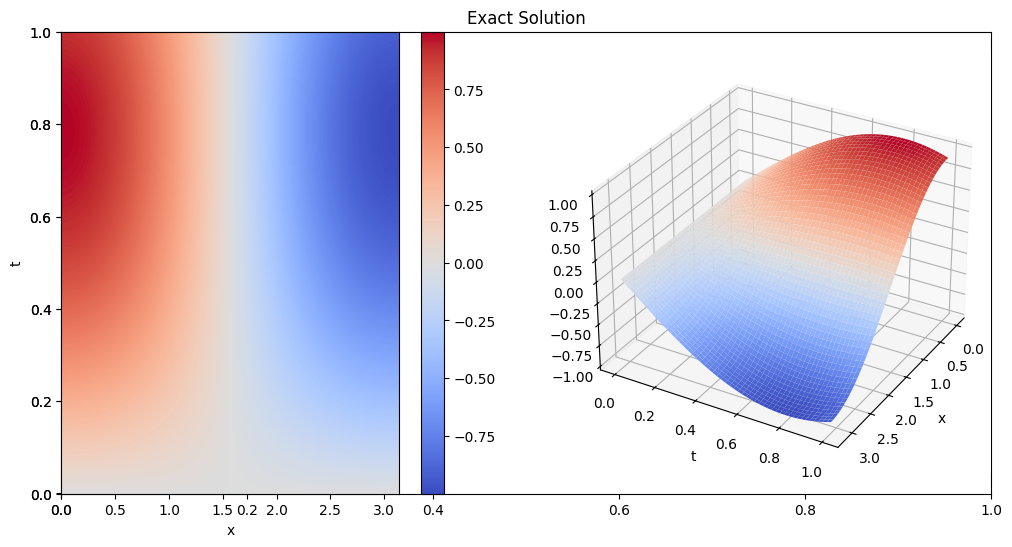

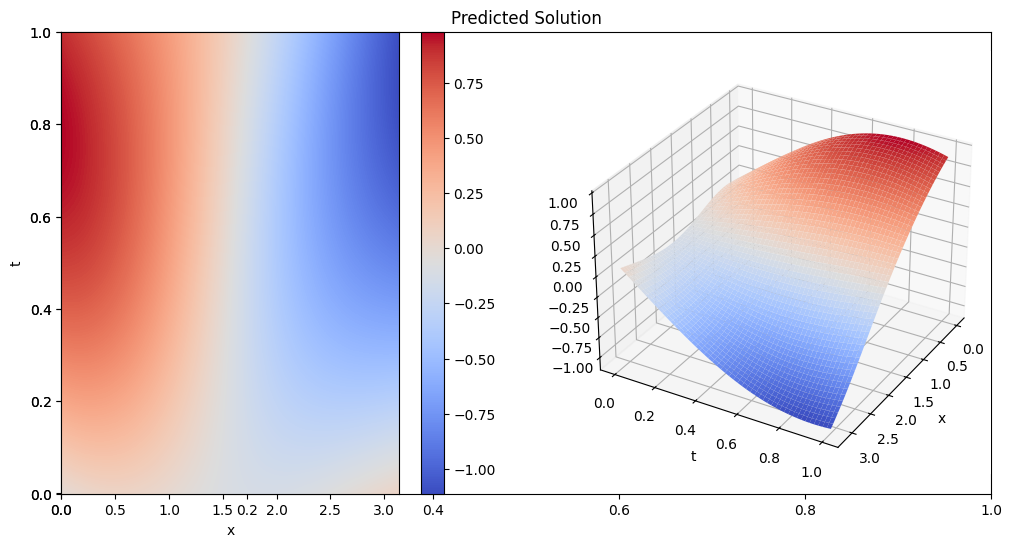

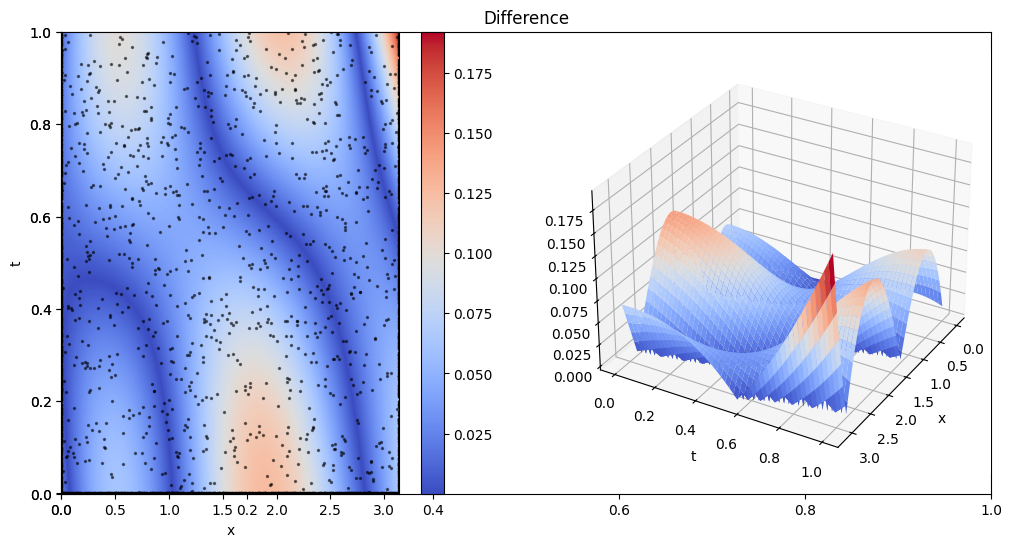

Mean absolute error: 0.047
Max absolute error: 0.192


In [90]:
plot_comparison()

2. **If the PDE residual $\biggr| \frac{\partial^2 u}{\partial t^2} - \frac{\partial^2 u}{\partial x^2} + 3u \biggr|$ is large at certain points in the domain, what could be the reason? Suggest two strategies to improve the solution.**

Reasons for high residual errors at certain points in the domain might be (a) the low expressiveness of the model or (b) too few collocation points in the visinity, which complicates the model to learn the certain area properly.

Besides the approach to use a more complex model architecture, one could deliberately use more sample points from that area.

Additionally, one could weight the loss terms differently, e.g. using a higher weight for the residual term to put more emphasis on the PDE's residual:

$$\mathcal{L} = \mathcal{L}_i + \alpha \mathcal{L}_b + \beta \mathcal{L}_r$$

In [85]:
# x = np.linspace(0, np.pi, 1000)
# t = np.linspace(0, 1, 1000)

# X, T = np.meshgrid(x, t)

# data = Data(
#         x_initial=torch.zeros(1),
#         t_initial=torch.zeros(1),
#         x_residual=torch.tensor(X.flatten(), requires_grad=True, dtype=torch.float32),
#         t_residual=torch.tensor(T.flatten(), requires_grad=True, dtype=torch.float32),
#         x_boundary_1=torch.zeros(1),
#         t_boundary_1=torch.zeros(1),
#         x_boundary_2=torch.ones(1),
#         t_boundary_2=torch.rand(1),
#     )

# u = model(data)

# sol = u.residual
# x = data.x_residual
# t = data.t_residual

# # calculate second derivative w.r.t. x
# dx = torch.autograd.grad(
#     sol, x, grad_outputs=torch.ones_like(sol), create_graph=True
# )[0]
# ddx = torch.autograd.grad(
#     dx, x, grad_outputs=torch.ones_like(sol), create_graph=True
# )[0]

# # calculate second derivative w.r.t. t
# dt = torch.autograd.grad(
#     sol, t, grad_outputs=torch.ones_like(t), create_graph=True
# )[0]
# ddt = torch.autograd.grad(
#     dt, t, grad_outputs=torch.ones_like(t), create_graph=True
# )[0]

# loss_r = torch.abs(ddx - 3 * u.residual - ddt)

# # plot residual loss on the grid
# plt.pcolormesh(X, T, loss_r.detach().numpy().reshape(X.shape), cmap="coolwarm")
# plt.xlabel("x")
# plt.ylabel("t")
# plt.title("Residual Loss")
# plt.colorbar()
# plt.show()
